# 07 Dynamic Model

*Splitting and evaluation of Dynamic Survival Models*

* * *

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from random import randrange
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from lifelines.datasets import load_dd
from lifelines import CoxPHFitter

from src.dd_column_cfg import id_col, drop_cols, cat_cols, num_cols, duration_col, event_col, target_cols

# Config

In [3]:
prediction_horizon=20

# Data

[Democracy and Dictatorship dataset](https://lifelines.readthedocs.io/en/latest/lifelines.datasets.html#lifelines.datasets.load_dd)

Classification of political regimes as democracy and dictatorship which covers 202 countries from 1946 or year of independence to 2008

In [4]:
data = load_dd()

data = data.reset_index().rename(columns={'index': id_col})
data.democracy = np.where(data.democracy=='Democracy', 1,0)
data['end_year'] = data.start_year + data.duration

data.shape

(1808, 14)

# Dynamic Splitting

## Fixed Dynamic Split

In [5]:
data_fsplit = data.copy()

In [6]:
split_year = 1988
data_fsplit['split_year'] = split_year

data_fsplit[['start_year', 'end_year', 'split_year']].sample(5)

,start_year,end_year,split_year
1784,1967,1969,1988
1103,1951,1955,1988
666,1992,1997,1988
349,1953,1958,1988
372,2003,2009,1988


In [7]:
data_fsplit = data_fsplit[(data_fsplit.start_year<split_year) & (data_fsplit.end_year>split_year)].copy()
len(data_fsplit) / len(data)

0.08185840707964602

In [8]:
data_fsplit['split_time'] = data_fsplit.split_year - data_fsplit.start_year
data_fsplit['duration_split'] = data_fsplit.end_year - data_fsplit.split_year

In [9]:
data_fsplit[['start_year', 'duration', 'end_year', 'split_year', 'split_time', 'duration_split']].sample(5)

,start_year,duration,end_year,split_year,split_time,duration_split
1626,1970,36,2006,1988,18,18
1276,1981,8,1989,1988,7,1
173,1985,4,1989,1988,3,1
325,1978,11,1989,1988,10,1
81,1986,11,1997,1988,2,9


## Random Dynamic Split

In [10]:
data_rsplit = data.copy()

In [11]:
data_rsplit['split_time'] = [randrange(start=0, stop=duration - 1)
 if duration >= 2 else 0
 for duration in data_rsplit.duration.values]

data_rsplit[f'{duration_col}_split'] = data_rsplit.duration - data_rsplit.split_time

In [12]:
data_rsplit[['duration', 'split_time', f'{duration_col}_split']].sample(5)

,duration,split_time,duration_split
243,2,0,2
1634,31,4,27
437,4,1,3
502,3,1,2
833,14,10,4


Add Augmentation at start point (you can add more random points with the method above, but remember to remove potential duplicates)

In [13]:
aug_start_df = data_rsplit.copy().sample(frac=0.5)
aug_start_df['split_time'] = 1
aug_start_df[f'{duration_col}_split'] = aug_start_df[duration_col]

aug_start_df.shape

(904, 16)

In [14]:
data_rsplit = pd.concat([data_rsplit, aug_start_df])
data_rsplit.shape

(2712, 16)

## Columns

Choose one of the splits to continue, from here on it is the same

We will use duration_split as the new target and add split_time as feature (num_cols)

In [15]:
data = data_rsplit.copy()

In [16]:
drop_cols = drop_cols + [duration_col]
duration_col = f'{duration_col}_split'
target_cols = [duration_col, event_col]

num_cols = num_cols + ['split_time']

drop_cols, target_cols, num_cols

(['ctryname',
  'cowcode2',
  'politycode',
  'ehead',
  'leaderspellreg',
  'start_year',
  'duration'],
 ['duration_split', 'observed'],
 ['split_time'])

In [17]:
data[cat_cols] = data[cat_cols].astype('category')

bin_cols = [n for n,col in data[cat_cols].items() if len(col.cat.categories) <= 2]
cat_cols = list(set(cat_cols) - set(bin_cols))

features = cat_cols + bin_cols + num_cols
col_order = num_cols + cat_cols + bin_cols + target_cols

# Train/Test Split

In [18]:
data_train, data_test = train_test_split(data, test_size=0.2)

data_train.shape, data_test.shape

((2169, 16), (543, 16))

# Transformer

In [19]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('target_cat', TargetEncoder())
])

transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
        ('passthrough', 'passthrough', bin_cols + target_cols),
        ('drop', 'drop', drop_cols + [id_col])
    ])

In [20]:
train = transformer.fit_transform(data_train, data_train[duration_col])
test = transformer.transform(data_test)

In [21]:
train = pd.DataFrame(train, columns=col_order)
test = pd.DataFrame(test, columns=col_order)

# Model

In [22]:
cph = CoxPHFitter()
cph.fit(train, duration_col=duration_col, event_col=event_col)

<lifelines.CoxPHFitter: fitted with 2169 total observations, 408 right-censored observations>

In [23]:
y_pred_surv = cph.predict_survival_function(test).round(3)

# Visualize Output

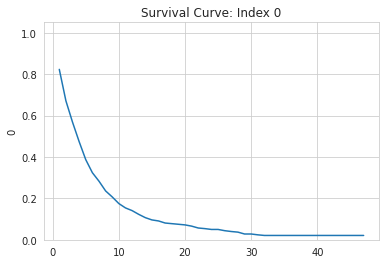

In [24]:
idx=0

sns.lineplot(data=y_pred_surv[idx])
plt.title(f'Survival Curve: Index {idx}')
plt.ylim(0,1.05);

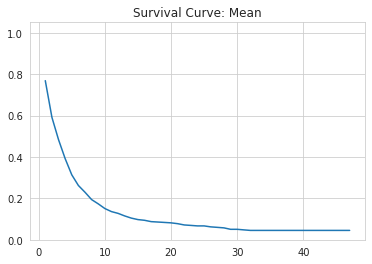

In [25]:
sns.lineplot(data=y_pred_surv.mean(axis=1))
plt.title('Survival Curve: Mean')
plt.ylim(0,1.05);

# Evaluation

Simulate prediction at every t by inserting split times from 1 to survival horizon as feature

In [26]:
res_list = []

for split_time in range(1, prediction_horizon+1):
    
    data_test.split_time = split_time
    test = transformer.transform(data_test)
    
    train = pd.DataFrame(train, columns=col_order)
    test = pd.DataFrame(test, columns=col_order)
    
    y_pred_surv = cph.predict_survival_function(test).iloc[:prediction_horizon].T.round(3)
    y_pred_surv['pred_t'] = split_time
    
    res_list.append(y_pred_surv)
    
res_df = pd.concat(res_list)
res_melt_df = res_df.melt(id_vars='pred_t', var_name='t', value_name='survival')
res_grpd_df = res_melt_df.groupby(['pred_t', 't'], as_index=False).agg({'survival': 'mean'})

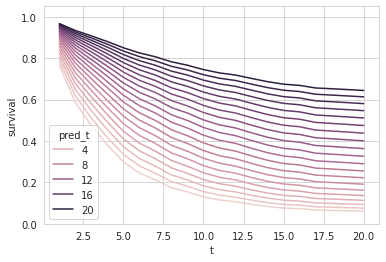

In [27]:
sns.lineplot(data=res_grpd_df, x='t', y='survival', hue='pred_t')
plt.ylim(0, 1.05);

In [28]:
res_grpd_df.t = res_grpd_df.t + res_grpd_df.pred_t - 1
res_grpd_df = res_grpd_df[res_grpd_df.t <= prediction_horizon]

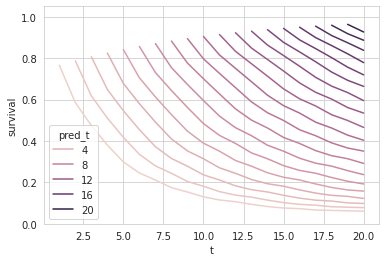

In [29]:
sns.lineplot(data=res_grpd_df, x='t', y='survival', hue='pred_t')
plt.ylim(0, 1.05);